# Choosing a Value of K

---

## Overview
This script is designed to help the user decide on k, the number of clusters/Cloud regimes to produce. It will preform clustering for values of k within the range specified by the user editable k_range variable. For each value of k, this script will create a range of plots First it will create a plot showing the correlation coefficents between the CR centers, then a plot showing the correlation between the space/time corelation of the CRs. Furthermore, after clustering for the first value of k is preformed, a correlation matrice will be made between the current and previous value of K. For example if you were testing values of k from 3 to 7, after the clustering for k=3 and 4 is preformed a plot of the correlations between the CRs from k=3 and k=4 will be created. This is useful to discern if increasing k by one has produced a genuinly new CR, or just split a CR that already existed. If all of the CRs for k=4 are "highly" correlated with a CR from k=3, then it's unlikely a new CR was created. The user can also set plot_cr_centers and plot_rfo_graphs to true, and plots of the CR centers as well as spacial maps will be shown for each value of k.

Choosing a value of k is still unfortunately not an exact science, and is a weak point in the CR workflow. Previous works have layed out specific conditons and correlation thresholds to define when k is large enough. However these thresholds and condtions tend to change over time, and correlation thresholds from one set of data may yeild un-ideal results when applied to a different set of data. However, here are the general steps and conditons that are used as outlined by [Tselioudis et al. 2013](https://journals.ametsoc.org/view/journals/clim/26/19/jcli-d-13-00024.1.xml):

1. Does clustering converge with a tolerance of 0.001? (This is automatically checked, and the user need not do anything)
2. Is this convergence insensitive to the intial centroids? (This is checked in the following chapter)
3. Is dispersion of all the vectors in each cluster minimized?
4. Does a distinctly new cluster appear when increasing k by 1?

Condition 1 is automatically checked by the code. If it is not met, an error will be raised and you will be prompted the change hyper-parameters of the k-means algorithm. However, when using wasserstein distance this value of tol (which is a measure of the total change in the cluster centers between iterations) will likely be much too small, and may need to be increased by quite a few orders of magnitude depending on the dataset to be able to reach convergence. Condtion 2 will be fully checked in the next chapter: Testing Cluster Robustness / Repeatability of Results. Condition 3 is a tricky one, and we do not really touch it here. It seems "the dispersion of all the vectors in each cluster (rms of each vector's distance from the centroid)" would decrease as k inreases and clusters become more compact, not necesarily reaching a minimum at some optimum value of k. Without additonal condtions or details that do not seem to be provided for this test, it is not particularly useful. Condition 4 is checked using the assortment of correlation matrices that this script will create. If two CRs have a high centroid correlation and space-time correlation with each other than it is likely that a CR has split (as oppose to a new one appearing) when increasing k by 1. This can be further checked by the k+1 correlation matrices. Typicaly studies will state specific correlation thresholds for CRs being too highly correlated (typically from 0.6-0.9 for histogram correlations), however these are not consistant across studies and cannot be consistent and continue to provide excellent results. 


## Prerequisites
 
It is important to have an understanding of the k-means clustering algorithm and how it works. Here's a [good starting resource](https://neptune.ai/blog/k-means-clustering) and [the documentation of sklearns k-means algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) for further documentation of all the variables. Also helpful is familarity with Xarray and NetCDF file formats.

- **Time to learn**: 30 minutes

- **System requirements**:
    - If you wish to use Wasserstein distance the [Wasserstein](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) package must be installed (and its ideal to have many processors at your disposal)
    - If you wish to run euclidean k-means on a gpu then the system must have an Nvidia GPU

---

## Imports

In [1]:
import numpy as np
import xarray as xr
from Functions import emd_means, euclidean_kmeans, plot_hists, plot_rfo, histogram_cor, spacial_cor, open_and_process, kp1_histogram_cor
import logging as lgr
import dask

## Defining Variables

Here we define the variables necesary to begin using the toy ISCCP dataset included with this cookbook. To start off leave these variables alone, but later on feel free to experiment. For example if you preform this analysis for only over land does the final value of k you decide on change? Is it smaller or larger? 

If running locally with your own dataset, you will need to change these to match your data.

In [9]:
# Path to data to cluster
data_path = "./ISCCP_toy_data.nc"

# Path to the directory you wish to save plots in if running as a script, if None plots will only be shown and not saved. Enter as String
save_path = None
save_prefix = None  # prefix to put into the name of each plot to distinguish different runs of this script

# Variable name of data to cluster in data_path
# Name of tau dimension for var_name
# Name of height/pressure dimension for var_name
var_name =  'n_pctaudist' 
tau_var_name =  'levtau' 
ht_var_name =  'levpc'
lat_var_name = 'lat'
lon_var_name = 'lon'

# Does this dataset use cloud top height or cloud top pressure? enter "h" for height or "p" for pressure
height_or_pressure = 'p'

# kmeans properties
tol = 0.001   # maximum change in inertia values between kmeans iterations to declare convergence. should be higher if using wasserstein distance
max_iter = 100   # maximum number of k-means iterations to preform for each initiation
init='k-means++'    # initialization technique for kmeans, can be 'k-means++', 'random', or initial clusters to use of shape (k, n_tau_bins * n_pressure_bins)
n_init = 100   # number of initiations of the k-means algorithm. The final result will be the initiation with the lowest calculated inertia
gpu = False  # If the user has an Nvidia GPU, euclidean clustering can br preformed on it for a very significant speed up. CUPY/CUML must be installed in conda environment.

# k sensitivity testing properties
k_range = [2,5] # minimum and maximum values for k to test

# Plot the CR centers and rfo maps? or just the correlation matricies
plot_cr_centers = True
plot_rfo_graphs = True

# Choose whether to use a euclidean or wasserstein distance kmeans algorithm
wasserstein_or_euclidean = "euclidean"

# Minimum and Maximum longitudes and latitudes entered as list, or None for entire range
lat_range = [-90,90]
lon_range = [-180,180]

# Time Range min and max, or None for all time, entered as list of str: Ex. ["2003-03-01", "2004-07-01"] or ['2003','2007']
time_range = None

# Use data only over land or over ocean
# Set to 'L' for land only, 'O' for ocean only, or False for both land and ocean
only_ocean_or_land = False
# Does this dataset have a built in variable for land fraction? if so enter as a string, otherwise cartopy will be used to mask out land or water
land_frac_var_name = None

# Logging level, set to "INFO" for information about what the code is doing, otherwise keep at "WARNING"
logging_level = 'INFO'

## Openining data and preprocessing for clustering.

In [4]:
# Setting up logger
lgr.root.setLevel(logging_level)
# Avoid creation of large chunks with dask
dask.config.set({"array.slicing.split_large_chunks": False})
# Automatically setting premade_cloud_regimes to none because this file does not need them. Do not Change.
premade_cloud_regimes = None
# Setting k to an arbitrary number as it wont be used but still must be passed
k=-1
# Concatenating save_path and save prefix
if save_path != None: save_path = save_path + save_prefix

# Opening and preprocessing data
mat, valid_indicies, ds, histograms, weights = open_and_process(data_path, k, tol, max_iter, init, n_init, var_name, tau_var_name, ht_var_name, lat_var_name, lon_var_name, height_or_pressure, wasserstein_or_euclidean, premade_cloud_regimes, lat_range, lon_range, time_range, only_ocean_or_land, land_frac_var_name, cluster = False)


INFO:root: Opening dataset:
INFO:root: Opening finished. Beginning preprocessing:
INFO:root: Reshaping data to shape (n_histograms, n_tau_bins* n_pc_bins):
INFO:root: Reading data into memory:
INFO:root: Finished preprocessing:


## Preforming Clustering
Preforming clustering for k in k_range and creating relevant plots. We'll debrief thes results below. 

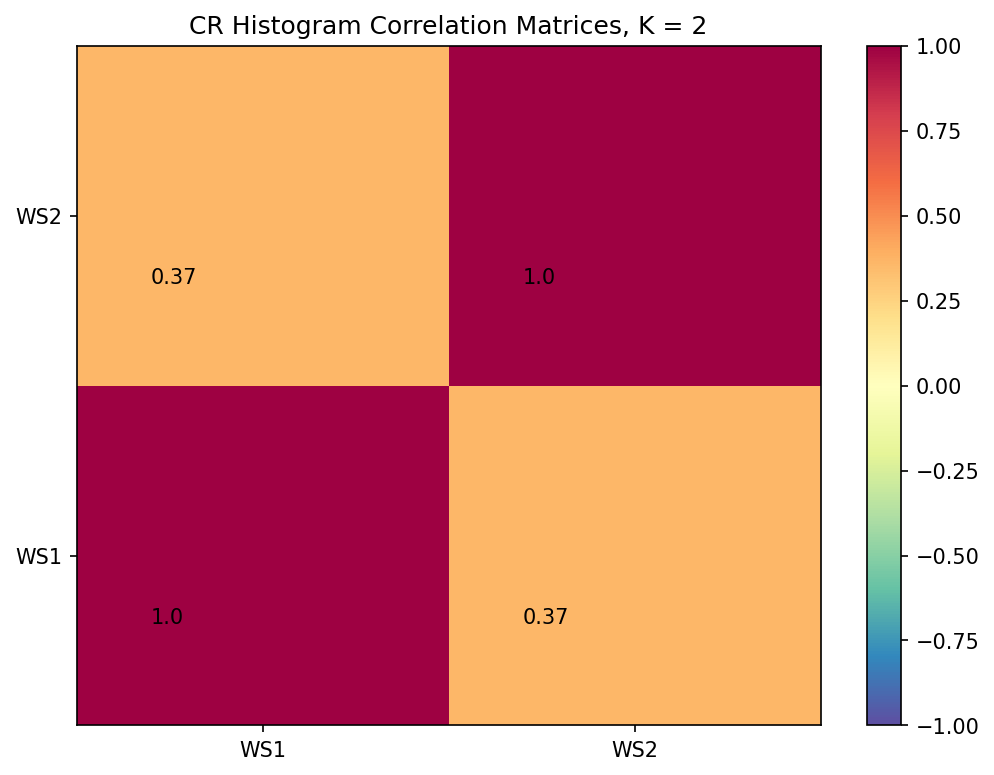

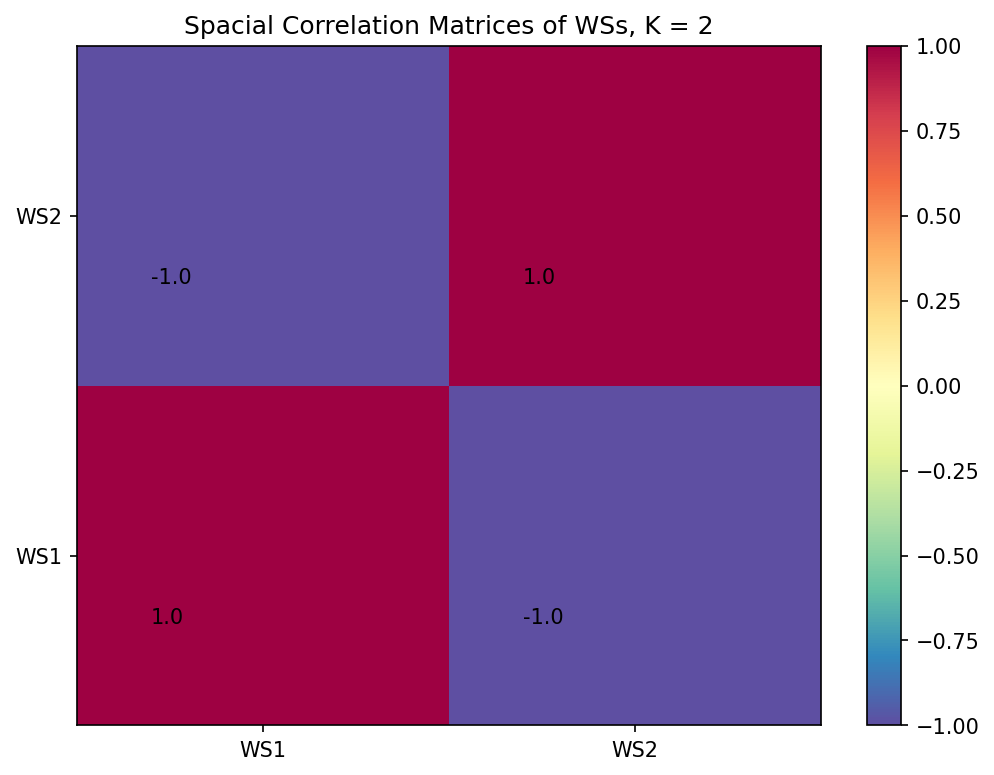

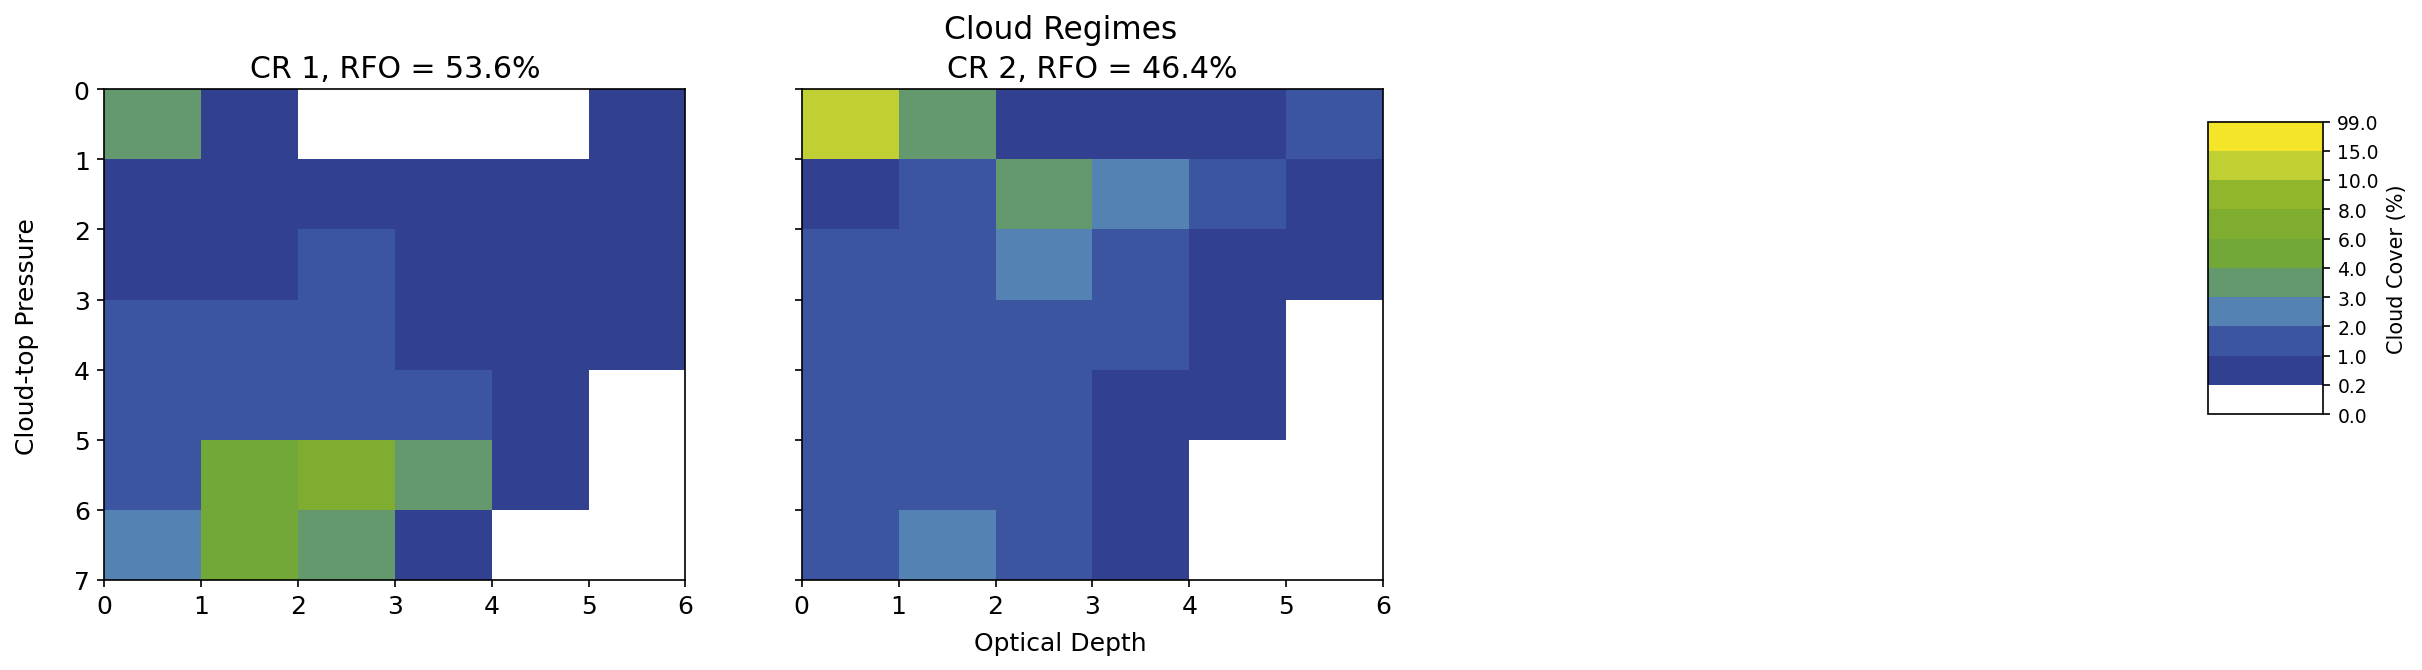

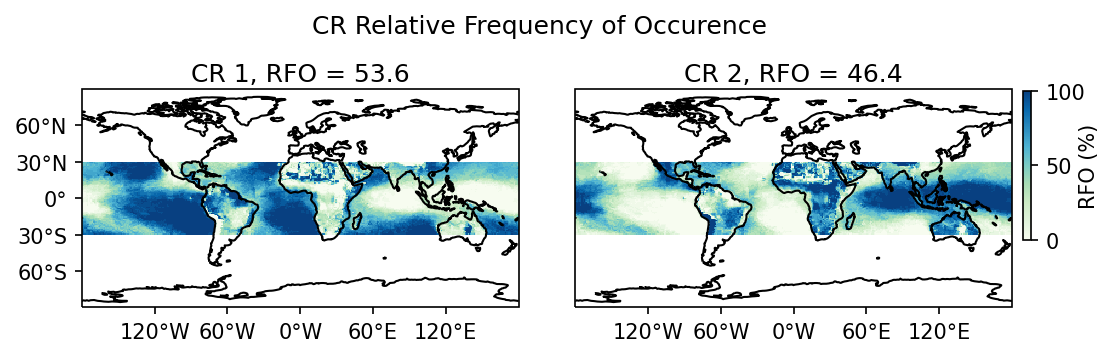

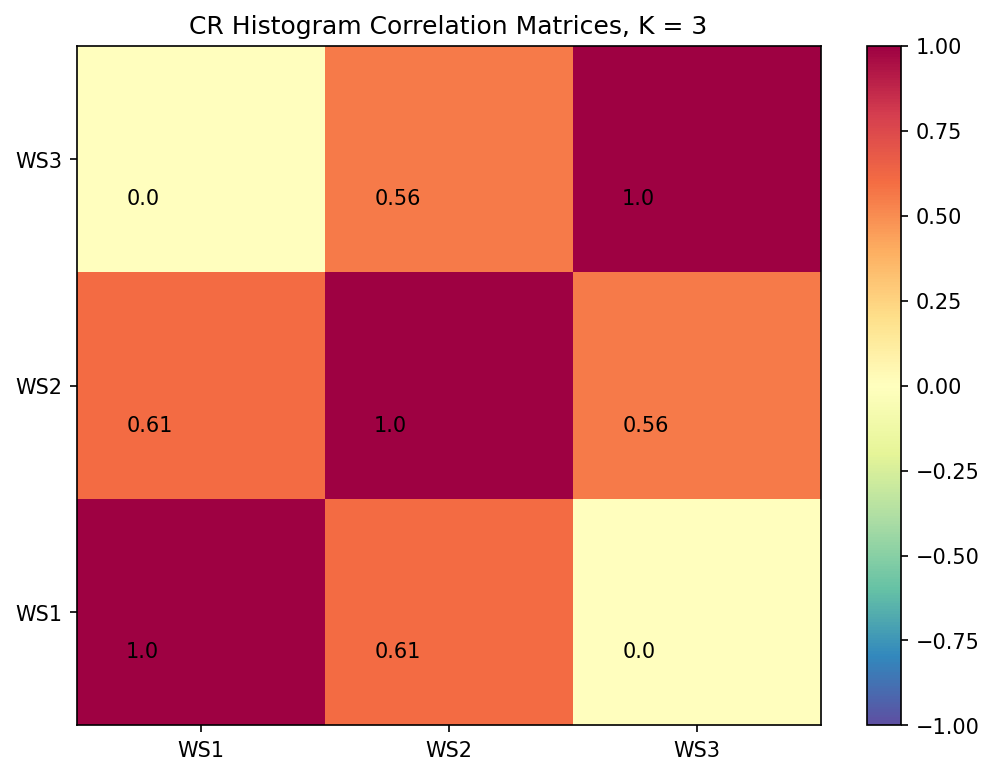

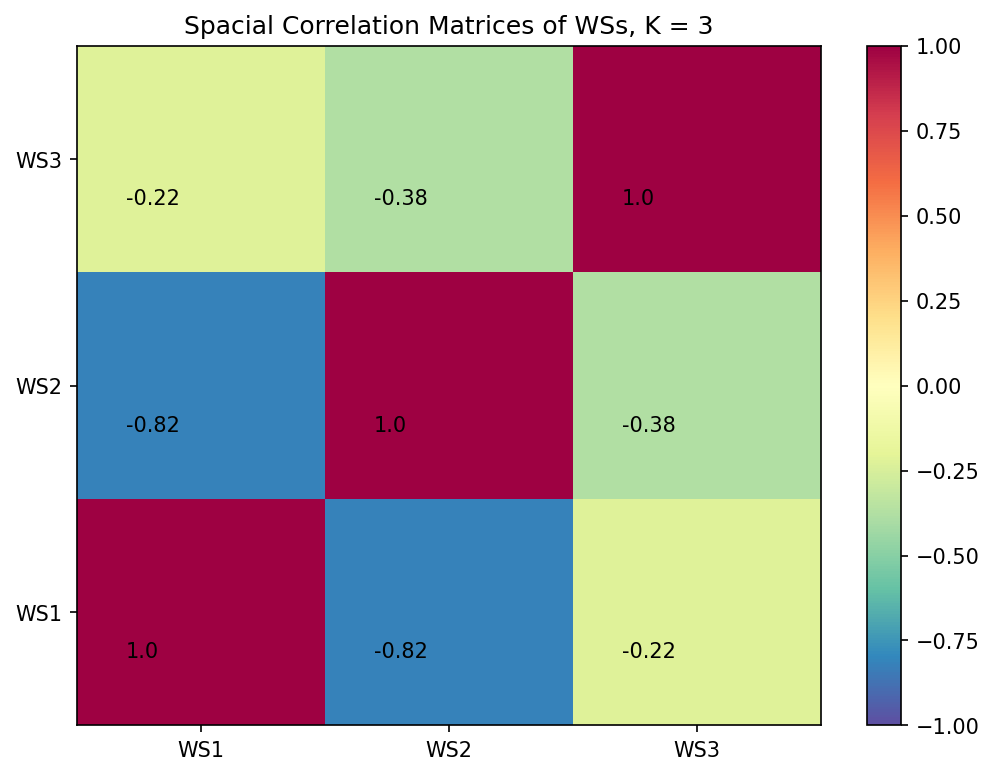

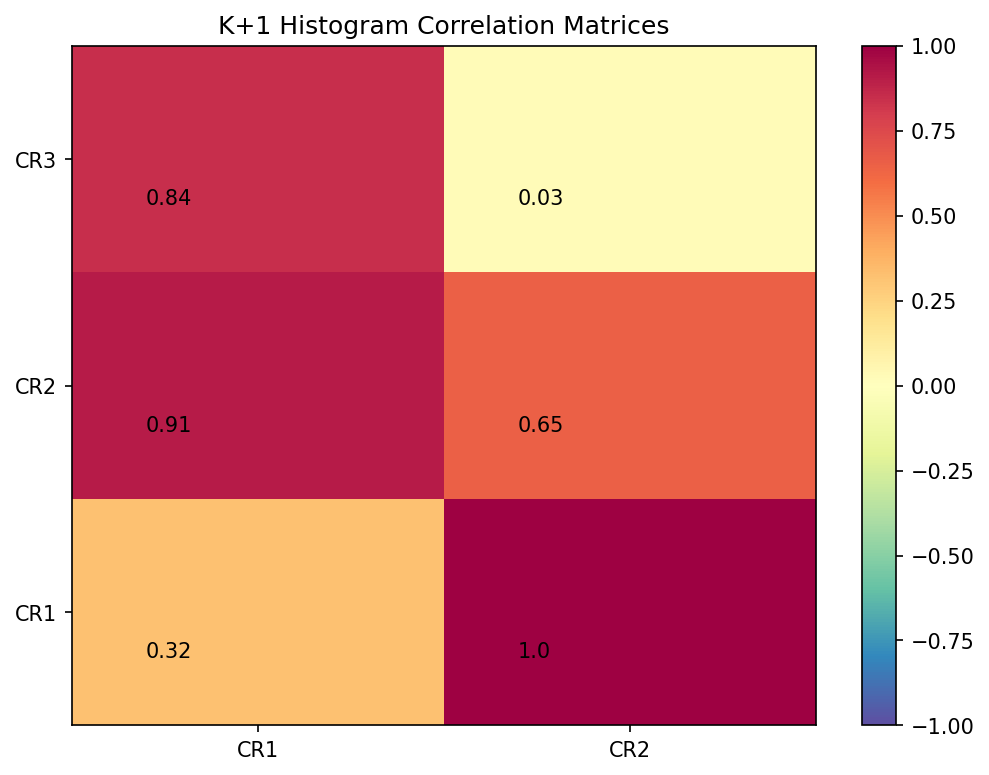

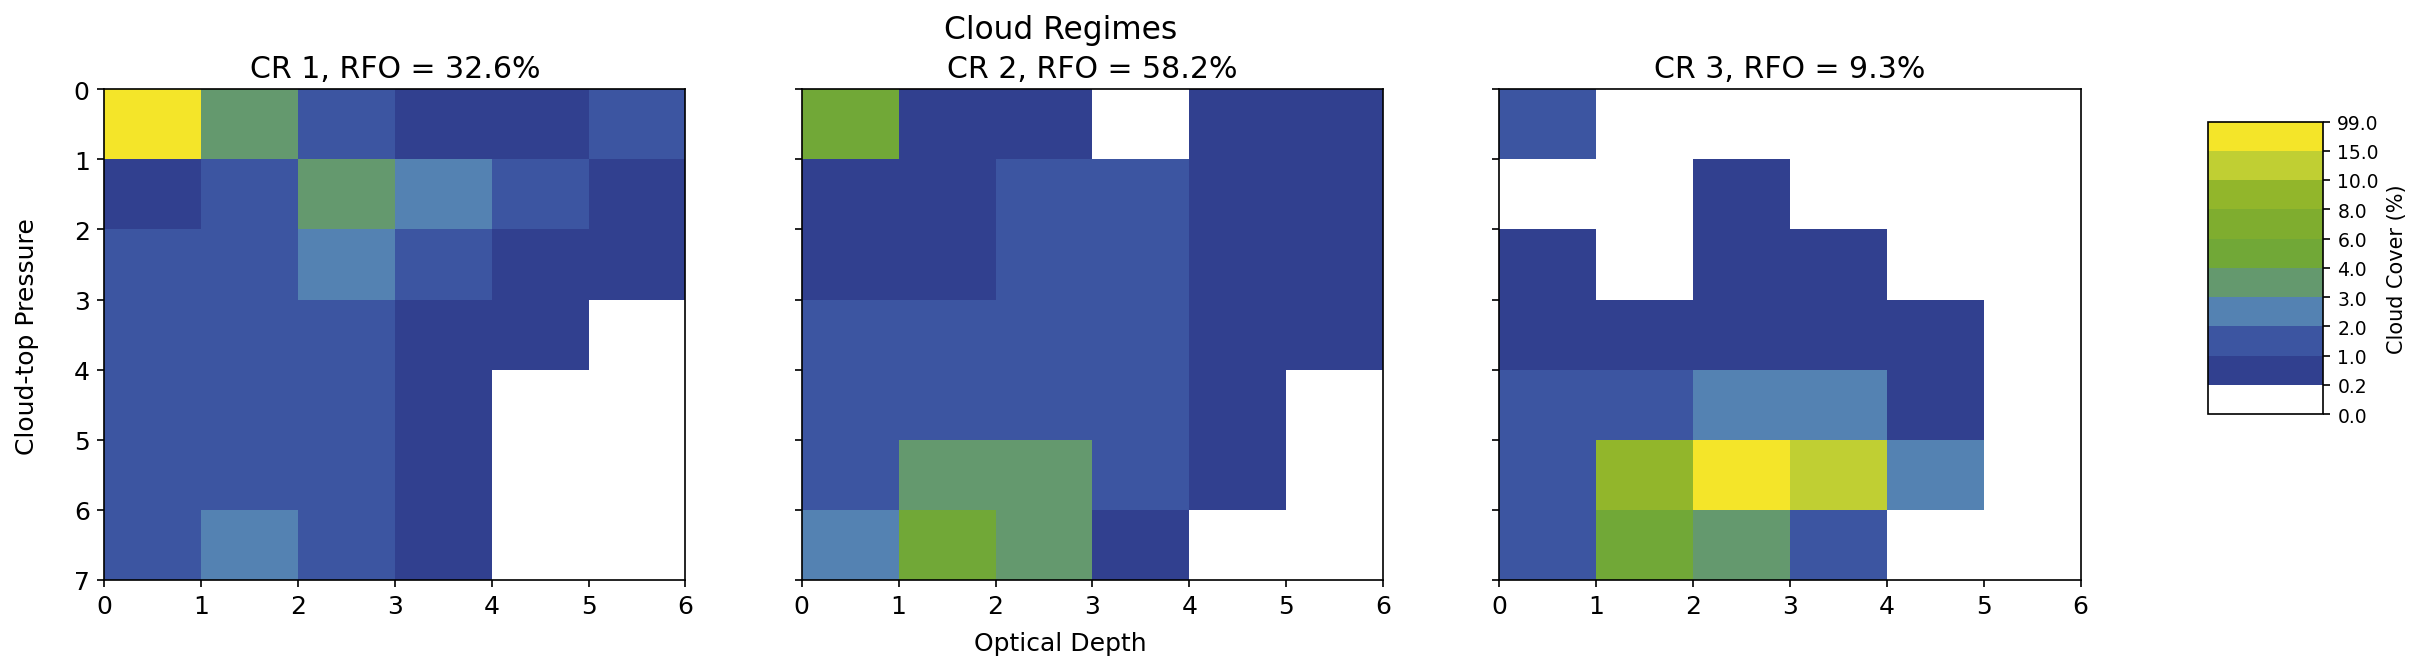

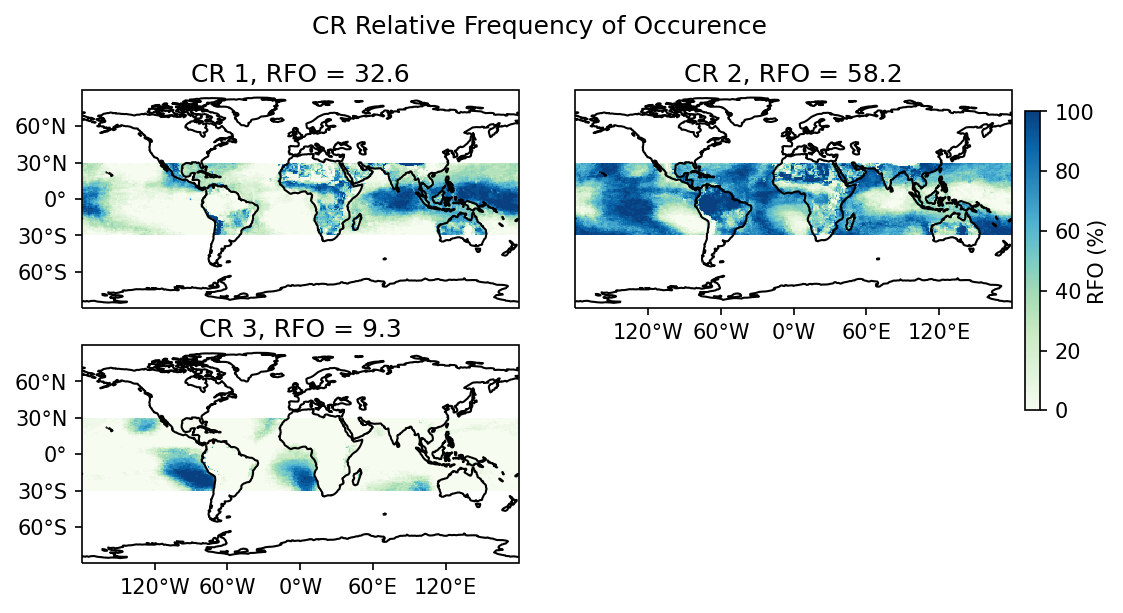

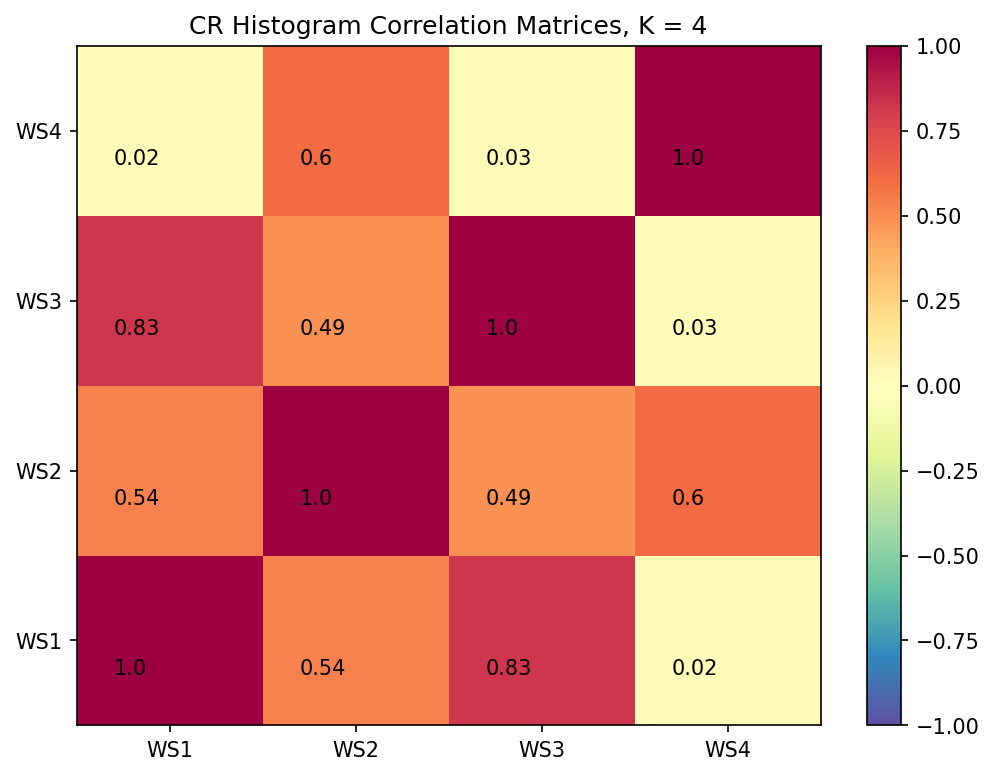

k = 4 failed the histogram correlation test. The maximum alowable correlation is 0.8, but the maximum correlation is 0.83


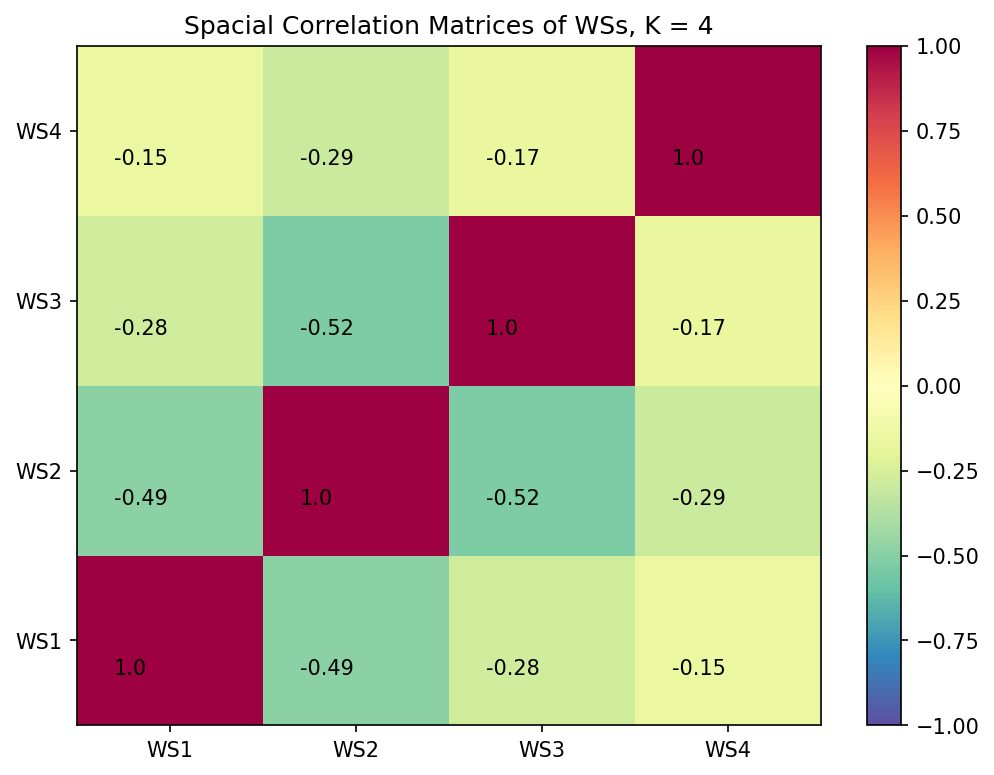

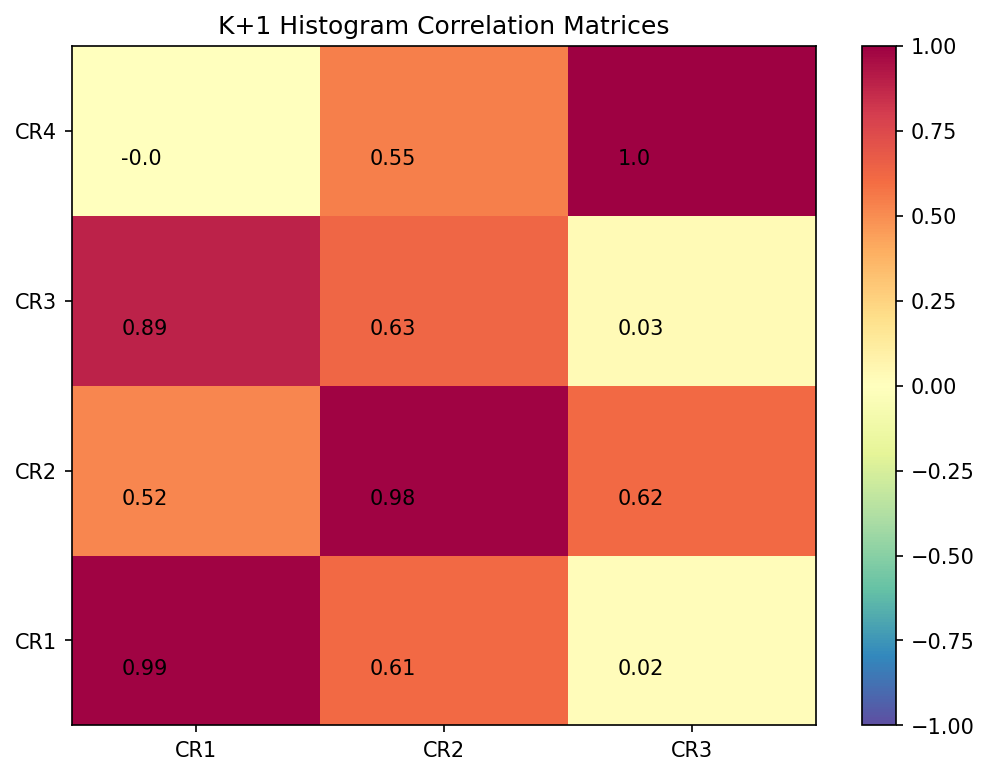

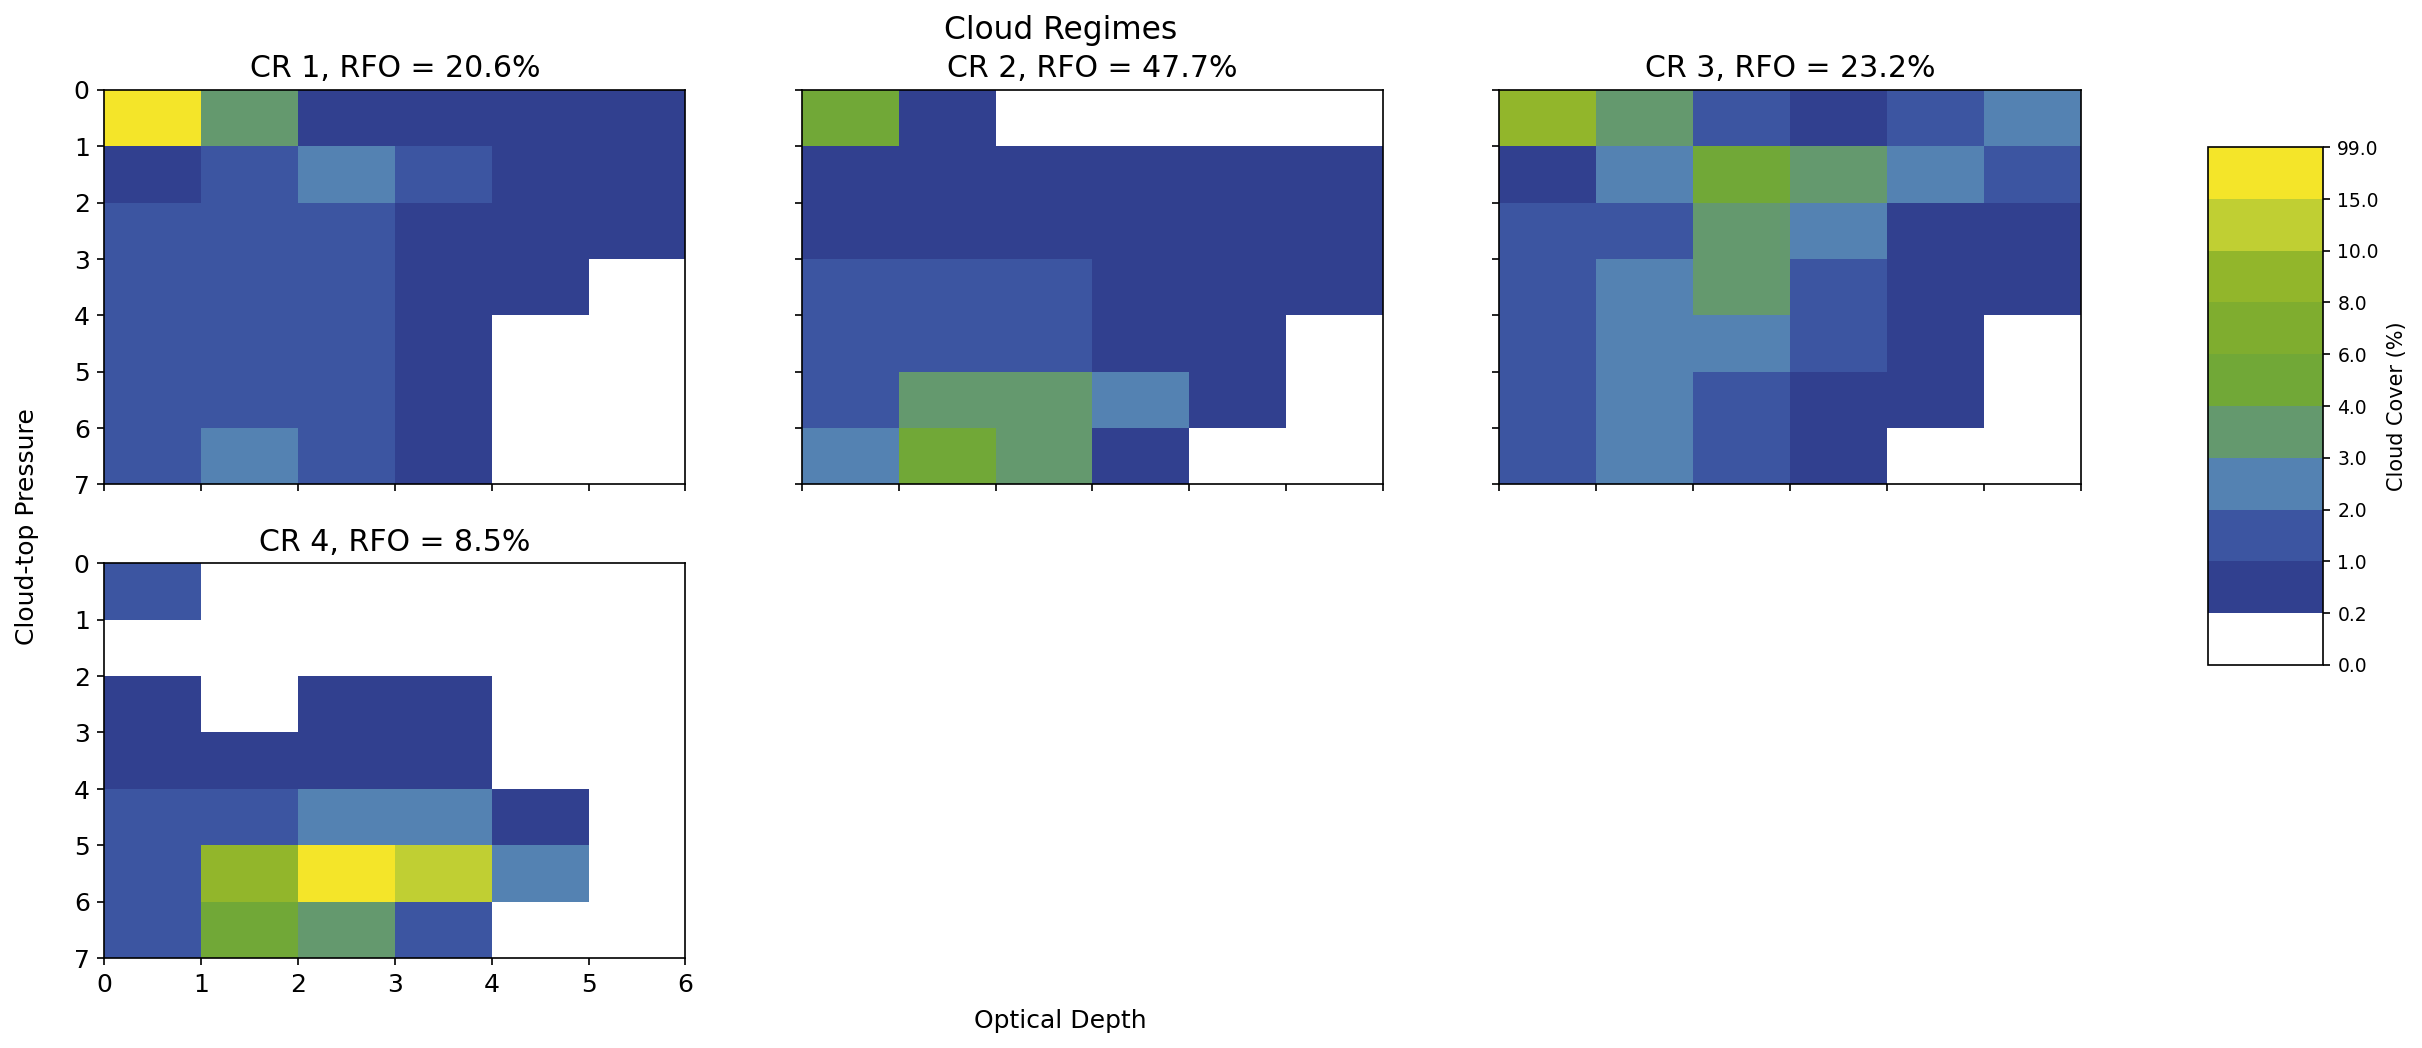

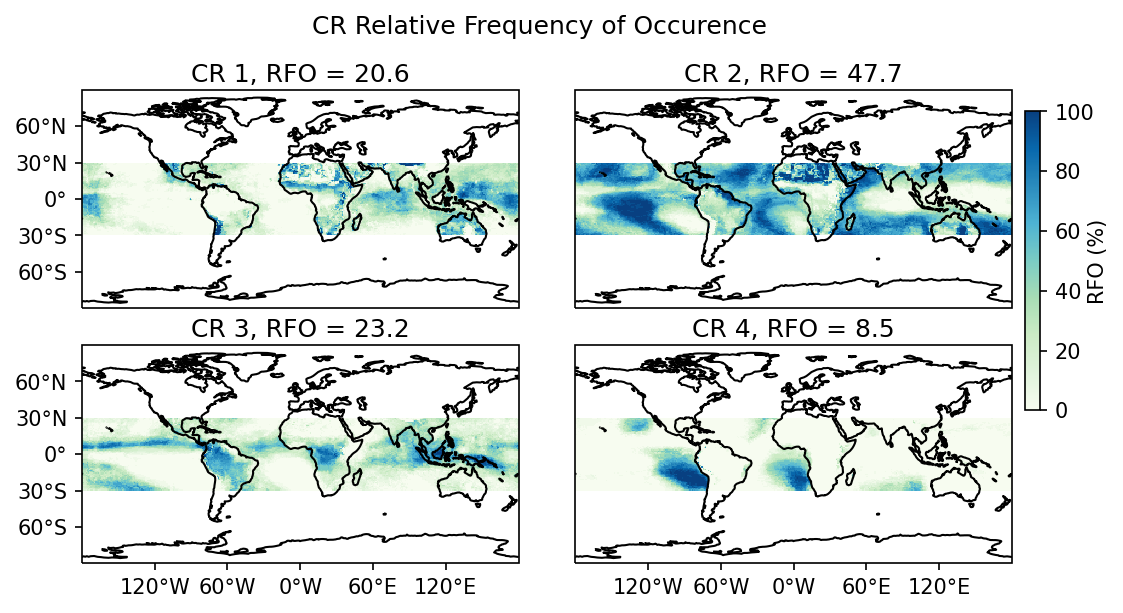

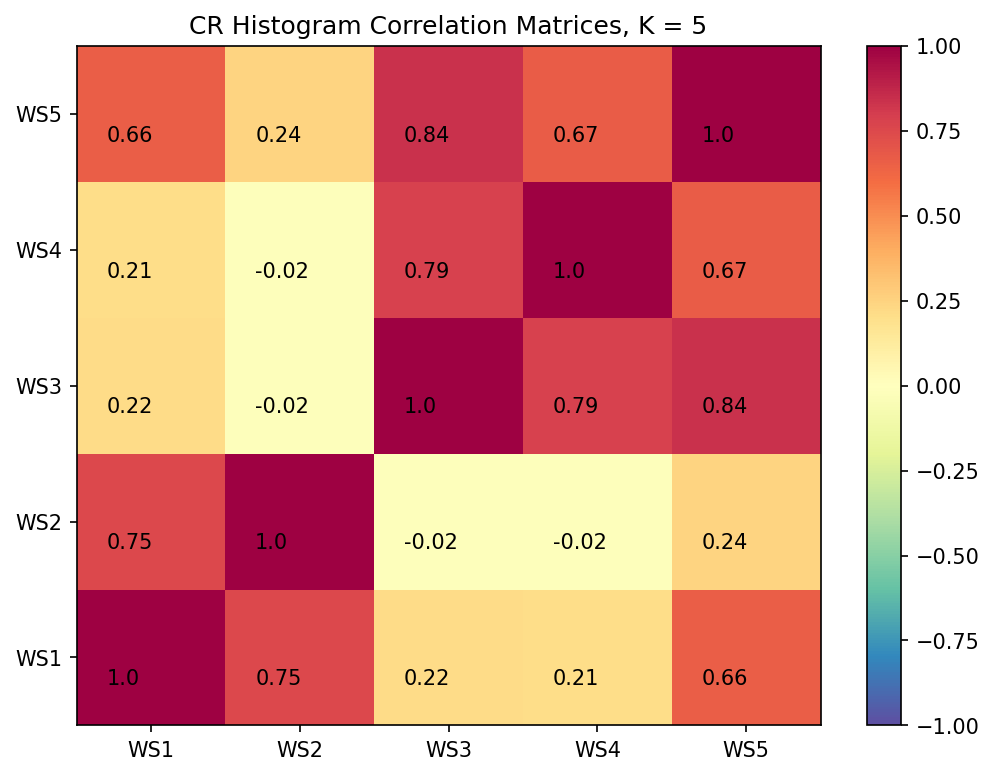

k = 5 failed the histogram correlation test. The maximum alowable correlation is 0.8, but the maximum correlation is 0.84


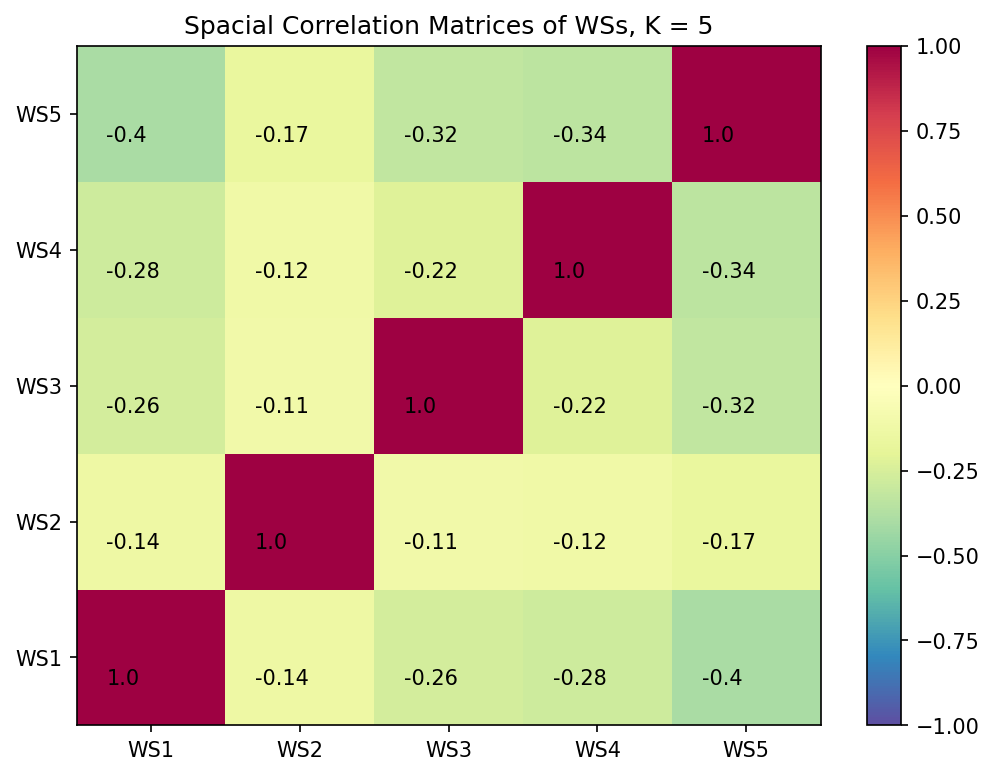

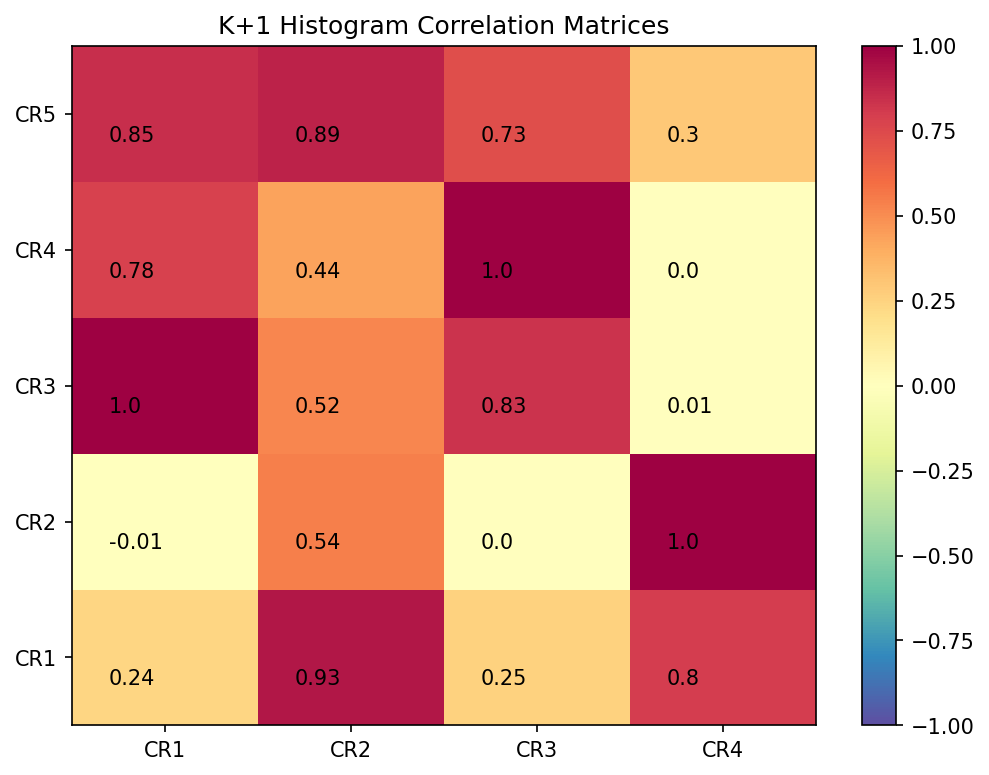

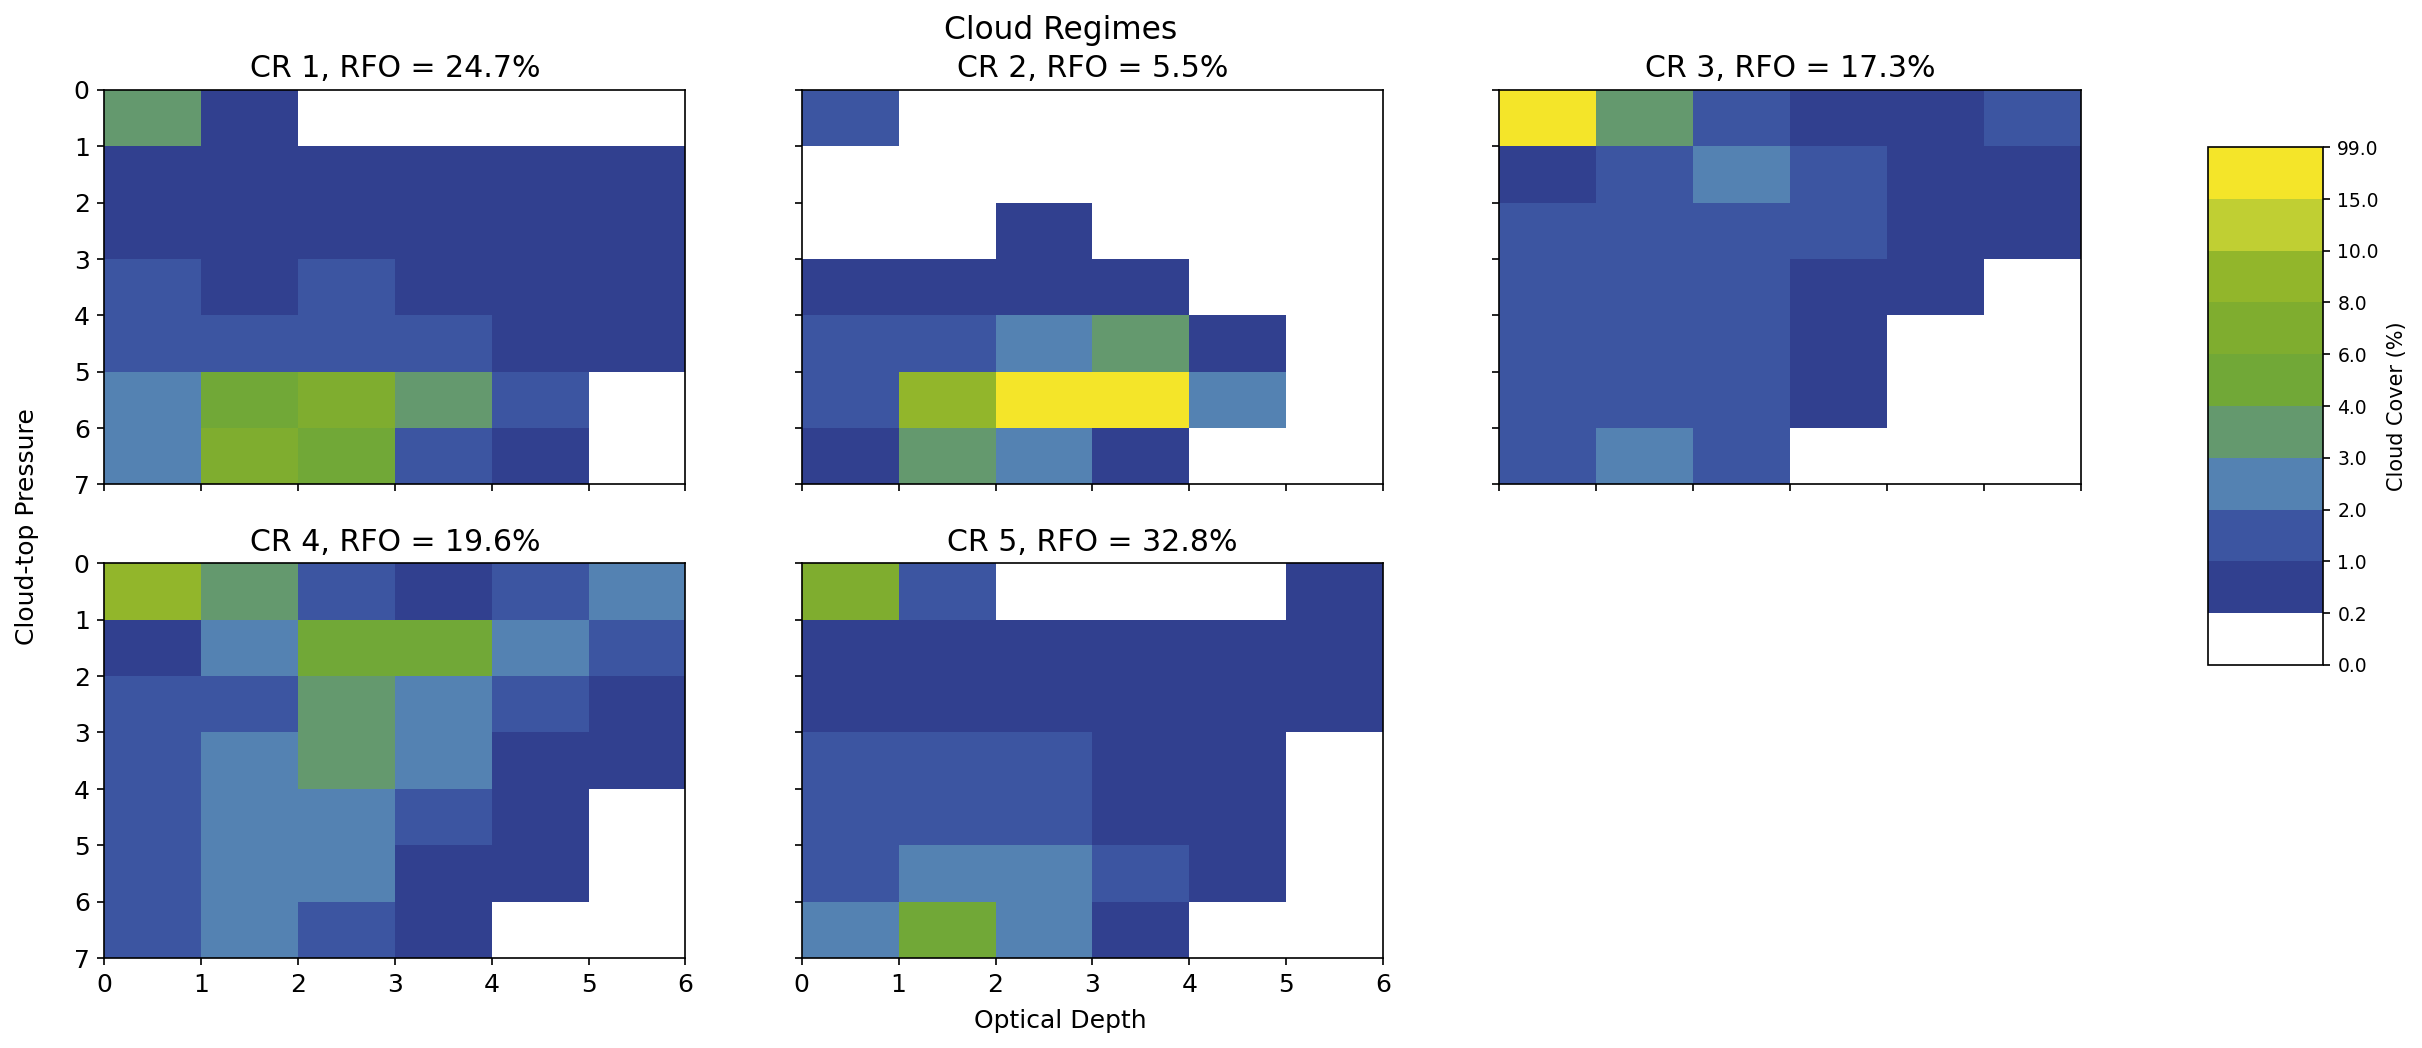

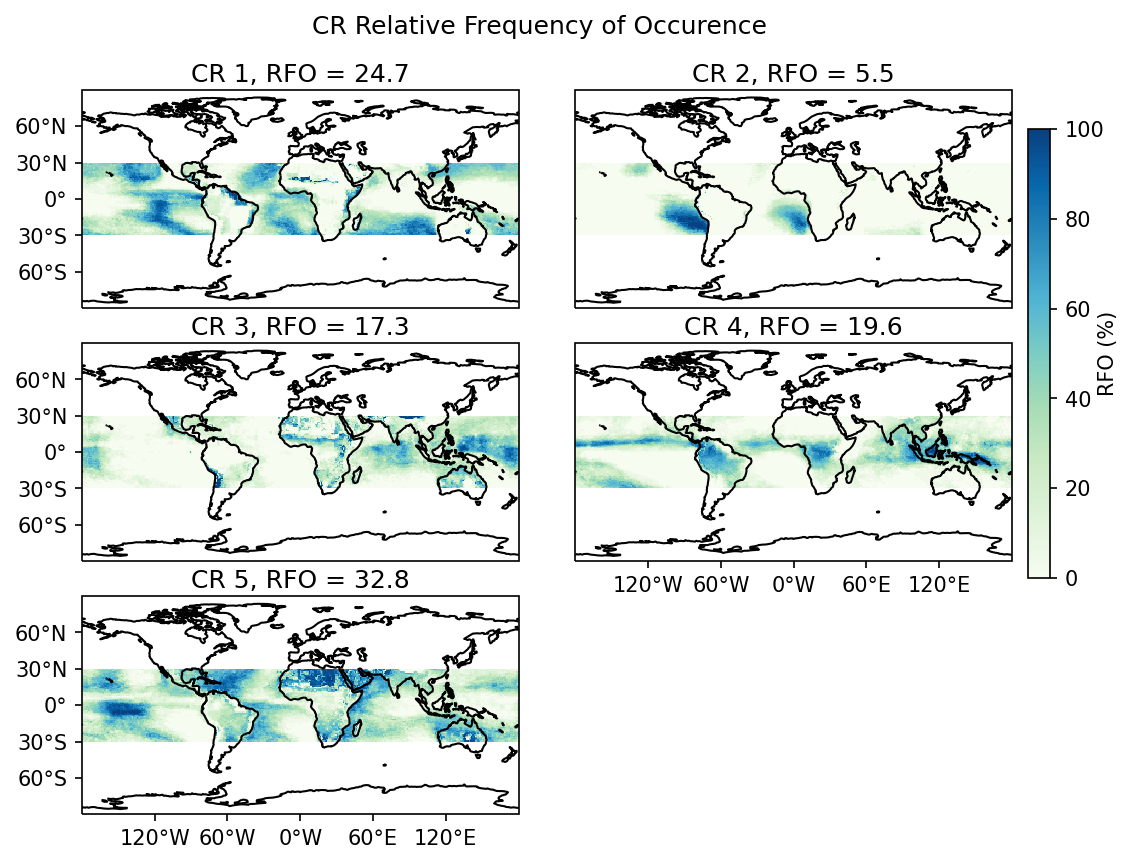

In [10]:
# Preform clustering with specified distance metric, for all values of k in k_range and create diagnostic plots
cl_list = [] # cariable to save cl for various values of k 
ratio_list = []
for i, k in enumerate(np.arange(k_range[0], k_range[1]+1)):
    if wasserstein_or_euclidean == "wasserstein":
        cl, cluster_labels_temp, il, cl_list = emd_means(mat, k=k, tol=tol, init=init, n_init = n_init, hard_stop=max_iter, weights=weights)
    elif wasserstein_or_euclidean == "euclidean":
        cl, cluster_labels_temp = euclidean_kmeans(k, init, n_init, mat, max_iter, tol, gpu)
    else: raise Exception ('Invalid option for wasserstein_or_euclidean. Please enter "wasserstein", "euclidean"')
    cl_list.append(cl)

    # Reshaping cluster_labels_temp to original shape of ds and reinserting NaNs in the original places, so spatial correlations can be calcualated
    cluster_labels = np.full(len(histograms), np.nan, dtype=np.int32)
    cluster_labels[valid_indicies]=cluster_labels_temp
    cluster_labels = xr.DataArray(data=cluster_labels, coords={"spacetime":histograms.spacetime},dims=("spacetime") )
    cluster_labels = cluster_labels.unstack()

    # Plotting correlation matrices
    histogram_cor(cl, save_path)
    spacial_cor(cluster_labels_temp,k, save_path)
    
    if i >0: kp1_histogram_cor(cl_list[i], cl_list[i-1], save_path)

    if plot_cr_centers:
        plot_hists(cluster_labels, k, ds, ht_var_name, tau_var_name, valid_indicies, mat, cluster_labels_temp, height_or_pressure, save_path)

    if plot_rfo_graphs:
        plot_rfo(cluster_labels,k,ds, save_path)

For the ISCCP toy data included in this cookbook, which includes only two years of monthly data from 30N to 30S, we see at k=2 it is initially seperated into essentially a low cloud and high cloud CR. Increasing k to 3 breaks up the low cloud CR into a thicker stratocumulus regime, and a thinner more general shollow convection regime. Increasing once again to K=4 breaks up the high cloud CR into a deep convection and a more general high cloud/cirrus CR. At k=5 our general low cloud/shallow convection CR splits once again, however this time, the split is highly correlated with other cloud regimes created in k=5. So here, I'd say that k=4 is the most ideal. 

---

### What's next?
Next we'll test how robust our k-means setup is, and make sure we can repeat the results of this clustering.